## Import of the necessary libraries

In [25]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
    KFold, 
    GroupKFold)

from xgboost import XGBClassifier
from sklearn.metrics import f1_score


In [2]:
train_raw = pd.read_csv('/Users/mjs/Desktop/Dev/Student_Performance/data/raw/train.csv')
train_labels = pd.read_csv('/Users/mjs/Desktop/Dev/Student_Performance/data/raw/train_labels.csv')

print('Train data shape:', train_raw.shape )
train_raw.head()

Train data shape: (26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


### EDA

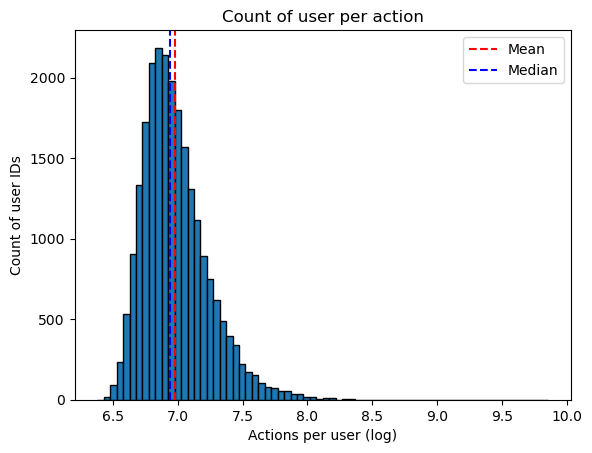

In [48]:
actions_users = train_raw.session_id.value_counts().values
log_actions = np.log(actions_users)

mean_value = np.mean(log_actions)
median_value = np.median(log_actions)

plt.hist(log_actions,bins = 70, edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(median_value, color='blue', linestyle='--', label='Median')

plt.xlabel('Actions per user (log)')
plt.ylabel('Count of user IDs')
plt.title('Count of user per action')

plt.legend()
plt.show()



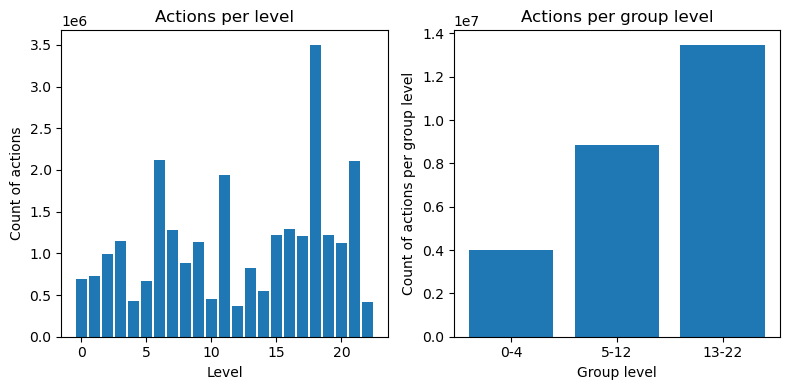

In [57]:
lvl = train_raw.level.value_counts()
lvl = lvl.sort_index()

lvl_grp = train_raw.level_group.value_counts()
reversed_lvl_grp = lvl_grp[::-1]


fig, axs = plt.subplots(1, 2, figsize=(8, 4))


axs[0].bar(lvl.index, lvl.values)
axs[0].set_xlabel('Level')
axs[0].set_ylabel('Count of actions')
axs[0].set_title('Actions per level')


axs[1].bar(reversed_lvl_grp.index, reversed_lvl_grp.values)
axs[1].set_xlabel('Group level')
axs[1].set_ylabel('Count of actions per group level')
axs[1].set_title('Actions per group level')

plt.tight_layout() 
plt.show()



## Labels
Splitting the question from the session_id for easier use

In [3]:
train_labels['session'] = train_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
train_labels['q'] = train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
train_labels.head()

#train_labels[train_labels['session'] == 20090312431273200]

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## Prepare the data

As mentioned in the description, there are three question checkpoints (level 4, level 12 and level 22), resulting in level segments 0-4, 5-12, 13-22. We will train three models for the corresponding segments. We use data from the level segment 0-4 for the questions 1-3. 

Later we also see the impact of using data from the level segment 0-4 for the questions 1-4.

Categorical variables need to be OHE

In [4]:
categorical = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
numeric = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in categorical:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in numeric:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in numeric:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [5]:
train_transf = feature_engineer(train_raw)
print("Full prepared dataset shape is {}".format(train_transf.shape))

train_transf.head()


Full prepared dataset shape is (70686, 22)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [6]:
df = train_transf
# Split the data
print(f"Full prepared dataset shape is {df.shape}")

train_ids, test_ids = train_test_split(df.index.unique(), test_size=0.25)
X_train_df = df.loc[train_ids]
X_test_df = df.loc[test_ids]

print(f"The training dataset shape is {X_train_df.shape}")
print(f"The test dataset shape is {X_test_df.shape}")
print(f"The training and test set are combined {(X_test_df.shape[0] + X_train_df.shape[0])}")

Full prepared dataset shape is (70686, 22)
The training dataset shape is (53013, 22)
The test dataset shape is (17673, 22)
The training and test set are combined 70686


In [7]:
xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    #'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4}

features = [c for c in X_train_df.columns if c != 'level_group']

print('We will train with', len(features) ,'features')
all_users = X_train_df.index.unique()

print('We will train with', len(all_users) ,'users info')
X_train_df

We will train with 21 features
We will train with 17671 users info


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20100107485528388,0-4,10,3,26,7,16,1.253917e+05,1.826389,-1.000000,-39.222975,...,383.911111,1408.250000,7.538807e+04,1.207956,-1.000000,431.106796,161.448838,235.654910,133.551291,2240.758848
20100107485528388,13-22,11,4,51,13,34,1.972148e+06,17.184369,4.000000,-198.082384,...,383.729670,656.930233,1.013810e+06,2.268626,0.000000,653.444783,214.150224,270.975447,117.318909,1406.321669
20100107485528388,5-12,11,4,40,11,26,6.327642e+05,8.353933,1.000000,-46.781527,...,345.596923,2311.066667,1.552708e+05,2.151583,0.000000,367.754816,141.075205,224.188201,124.059775,2458.128050
21010211495871650,0-4,10,4,25,7,14,1.217546e+05,1.774194,0.285714,-118.043966,...,363.646667,9067.250000,6.015164e+04,1.192773,0.487950,412.956684,166.474027,253.180752,135.619292,7988.502754
21010211495871650,13-22,11,4,56,14,33,2.092933e+06,17.579568,5.111111,-95.654751,...,440.015419,727.944444,2.122402e+05,2.320750,0.927961,588.209856,236.944110,244.027365,118.555646,1086.552787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100015125877780,13-22,10,3,60,13,34,1.253401e+06,17.439189,-1.000000,-182.893228,...,384.215356,924.298246,1.679679e+05,2.454945,-1.000000,635.819559,246.424471,255.010870,124.215755,1257.039023
20100015125877780,5-12,10,3,42,11,24,4.507642e+05,8.344262,-1.000000,5.430263,...,323.726236,1365.609756,1.218315e+05,2.172535,-1.000000,364.376724,147.323330,203.367189,123.774948,2147.736586
21030409345347612,0-4,10,4,23,6,12,1.004253e+05,1.884615,0.000000,29.137674,...,342.887097,1132.000000,6.109241e+04,1.297790,0.000000,453.816811,152.897472,229.711640,111.060974,1321.988843


In [9]:
X_train = X_train_df
X_test = X_test_df


pred = np.empty((0,)) 
pred_proba = np.empty((0,2))

# Create a model for each question - loop through each question
for t in range(1,19):
    
    if t <= 3: grp = '0-4'

    elif t<=13: grp = '5-12'

    elif t<=22: grp = '13-22'


    # Get the data corresponding to the level group
    
    X_train_grp = X_train[X_train['level_group'] == grp]
    X_train_users = X_train_grp.index.values
    y_train = train_labels.loc[train_labels.q==t].set_index('session').loc[X_train_users]
    
    # Validation data
    X_test_grp = X_test[X_test['level_group'] == grp]
    
    # Instantiate model
    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train_grp[features].astype('float32'), y_train['correct'], verbose = 0)
    
    # Test against the test set
    clf_predictions = clf.predict(X_test_grp[features].astype('float32'))
    clf_predictions_proba = clf.predict_proba(X_test_grp[features].astype('float32'))

    pred = np.concatenate((pred, clf_predictions))
    pred_proba = np.concatenate((pred_proba, clf_predictions_proba))


In [24]:
# See the metrics for the independent test set
# Select the test users
X_test_users = X_test_grp.index.values
y_test = train_labels.set_index('session').loc[X_test_users]['correct'].values

f1 = f1_score(y_test, pred)

print("F1 score:", f1)


F1 score: 0.7643271522124002


## See the results

In [121]:


# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

NameError: name 'oof' is not defined

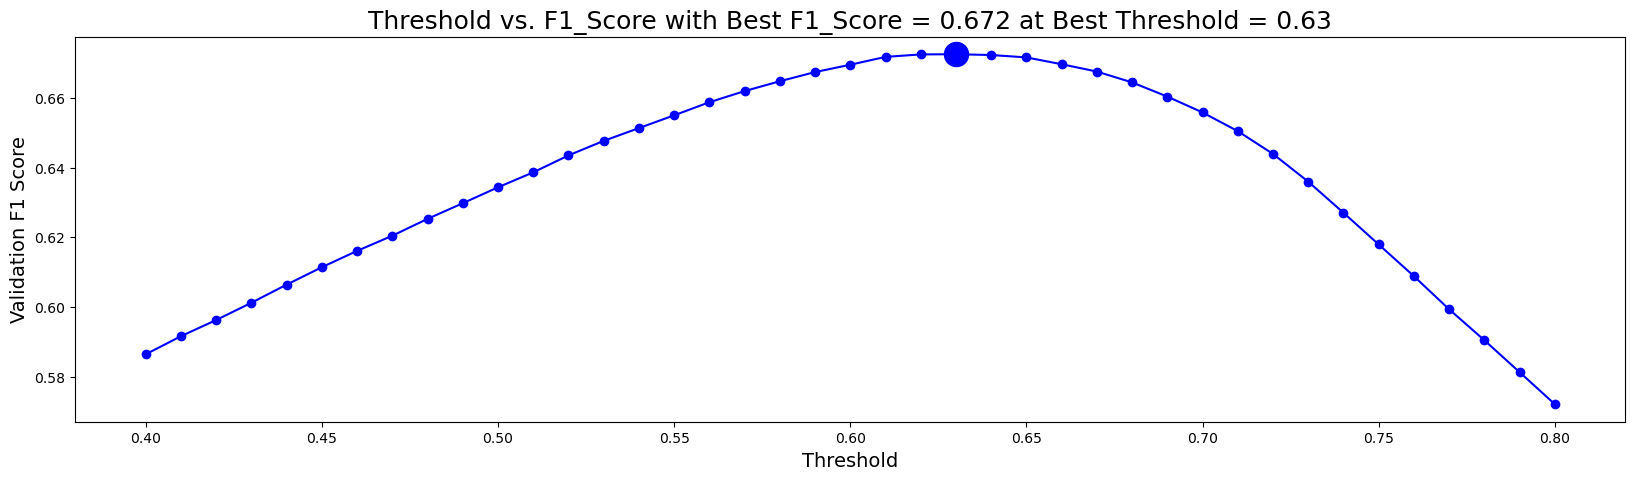

In [50]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

## Save the results of the experiments

In [26]:

# Example data for demonstration
experiments = [
    {'Model': 'Model 1', 'Parameter': 'No changes - no KFold', 'F1': f1}
]

# Save the experiments to a JSON file
with open('experiment_results.json', 'w') as file:
    json.dump(experiments, file)



In [ ]:
# Add a new experiment
new_experiment = {'Model': 'Model 4', 'Parameter': 'B', 'F1': 0.95}

# Load existing experiments from the JSON file
with open('experiment_results.json', 'r') as file:
    existing_experiments = json.load(file)

# Append the new experiment
existing_experiments.append(new_experiment)

# Save the updated experiments to the JSON file
with open('experiment_results.json', 'w') as file:
    json.dump(existing_experiments, file)# Add a new experiment
new_experiment = {'Model': 'Model 4', 'Parameter': 'B', 'F1': 0.95}

# Load existing experiments from the JSON file
with open('experiment_results.json', 'r') as file:
    existing_experiments = json.load(file)

# Append the new experiment
existing_experiments.append(new_experiment)

# Save the updated experiments to the JSON file
with open('experiment_results.json', 'w') as file:
    json.dump(existing_experiments, file)